## Question
What impact does a country's economic status (as measured by GDP and other factors) affect the number of human trafficking cases reported in that country?

### Model
Based on a known dataset, can linear regression be used to determine any relationship between the number of victims of human trafficking each year in a given country and that country's GDP?

### Output
We hope to find a line where as GDP, unemployment and other factors change, the number of human trafficking cases may be predicted. If the number of cases can be predicted/modeled, one of two outcomes may be possible:
* Examine existing cases for possible under-reporting and encouraging law enforcement to act more pro-actively.
* Allow leadership in given countries the opportunity to curb trafficking by improving economic conditions within their respective country.

In [1]:
# Import Dependencies
import os
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from config import conn

# from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Get trafficking data
trafficking_df = pd.read_sql_table("Trafficking_Cleaned", conn)
trafficking_df

,yearOfRegistration,Datasource,gender,citizenship,isForcedLabour,ControlCategory,RecruiterCategory,ExploitType,Labor_Type,ageCategories
0,2012,Case Management,Female,LK,1,Threats,Other,Forced Labor,Domestic Work,Age 30-38
1,2012,Case Management,Female,LK,1,Financial,Other,Forced Labor,Domestic Work,Age 30-38
2,2012,Case Management,Female,LK,1,Threats,Other,Forced Labor,Domestic Work,Age 30-38
3,2012,Case Management,Female,LK,1,Financial,Other,Forced Labor,Domestic Work,Age 30-38
4,2012,Case Management,Female,LK,1,Financial,Other,Forced Labor,Domestic Work,Age 30-38
...,...,...,...,...,...,...,...,...,...,...
14294,2018,Hotline,Male,US,0,Threats,Family/Relative,Sexual Exploitation,Unknown,Age 9-17
14295,2018,Hotline,Male,US,0,Threats,Family/Relative,Sexual Exploitation,Unknown,Age 9-17
14296,2018,Hotline,Male,US,0,Threats,Family/Relative,Sexual Exploitation,Unknown,Age 9-17
14297,2018,Hotline,Male,US,0,Other,Family/Relative,Sexual Exploitation,Unknown,Age 9-17


In [3]:
# Get total case counts for each country by year
cases_by_year = trafficking_df.groupby(["citizenship", "yearOfRegistration"]).size().reset_index(name="case_counts")
cases_by_year

,citizenship,yearOfRegistration,case_counts
0,0,2015,811
1,0,2016,1860
2,0,2017,2448
3,0,2018,3234
4,AF,2013,3
5,AF,2014,1
6,BY,2015,90
7,BY,2016,112
8,BY,2017,30
9,CN,2017,11


In [4]:
# Get country data
countries_df = pd.read_sql_table("Country_Codes", conn)
countries_df

,country_name,country_iso2,country_iso3,country_un_code
0,Afghanistan,AF,AFG,4
1,Aland Islands,AX,ALA,248
2,Albania,AL,ALB,8
3,Algeria,DZ,DZA,12
4,American Samoa,AS,ASM,16
...,...,...,...,...
242,Wallis and Futuna Islands,WF,WLF,876
243,Western Sahara,EH,ESH,732
244,Yemen,YE,YEM,887
245,Zambia,ZM,ZMB,894


In [5]:
# Merge our country code cross-reference to our aggregated cases per country per year
trafficking_x_countries = cases_by_year.merge(countries_df, how='left', left_on='citizenship', right_on='country_iso2')
trafficking_x_countries

,citizenship,yearOfRegistration,case_counts,country_name,country_iso2,country_iso3,country_un_code
0,0,2015,811,NaN,NaN,NaN,NaN
1,0,2016,1860,NaN,NaN,NaN,NaN
2,0,2017,2448,NaN,NaN,NaN,NaN
3,0,2018,3234,NaN,NaN,NaN,NaN
4,AF,2013,3,Afghanistan,AF,AFG,4
5,AF,2014,1,Afghanistan,AF,AFG,4
6,BY,2015,90,Belarus,BY,BLR,112
7,BY,2016,112,Belarus,BY,BLR,112
8,BY,2017,30,Belarus,BY,BLR,112
9,CN,2017,11,China,CN,CHN,156


In [6]:
# Replace the `0` placeholder for unknowns with null/NaN values.
trafficking_x_countries["citizenship"].replace({'0': np.nan}, inplace=True)
trafficking_x_countries.dropna(inplace=True)
trafficking_x_countries

,citizenship,yearOfRegistration,case_counts,country_name,country_iso2,country_iso3,country_un_code
4,AF,2013,3,Afghanistan,AF,AFG,4
5,AF,2014,1,Afghanistan,AF,AFG,4
6,BY,2015,90,Belarus,BY,BLR,112
7,BY,2016,112,Belarus,BY,BLR,112
8,BY,2017,30,Belarus,BY,BLR,112
9,CN,2017,11,China,CN,CHN,156
10,CN,2018,12,China,CN,CHN,156
11,ER,2014,1,Eritrea,ER,ERI,232
12,HT,2012,89,Haiti,HT,HTI,332
13,ID,2014,1,Indonesia,ID,IDN,360


In [7]:
# Get the GDP data from our database, convert to DataFrame and merge on to our aggregated data.
gdp_df = pd.read_sql_table("WEO_GDP", conn, index_col=["ISO"])

year_gdp = []
for row in trafficking_x_countries.iterrows():
    year_gdp.append(gdp_df.loc[row[1]['country_iso3'], str(row[1]['yearOfRegistration'])])

# Add our results to our cumulative DataFrame
trafficking_x_countries['GDP'] = year_gdp

In [8]:
trafficking_x_countries

,citizenship,yearOfRegistration,case_counts,country_name,country_iso2,country_iso3,country_un_code,GDP
4,AF,2013,3,Afghanistan,AF,AFG,4,754.402
5,AF,2014,1,Afghanistan,AF,AFG,4,747.622
6,BY,2015,90,Belarus,BY,BLR,112,5941.240
7,BY,2016,112,Belarus,BY,BLR,112,5022.470
8,BY,2017,30,Belarus,BY,BLR,112,5757.290
9,CN,2017,11,China,CN,CHN,156,8823.460
10,CN,2018,12,China,CN,CHN,156,9919.810
11,ER,2014,1,Eritrea,ER,ERI,232,786.540
12,HT,2012,89,Haiti,HT,HTI,332,1337.340
13,ID,2014,1,Indonesia,ID,IDN,360,3533.610


In [9]:
# Split to our 'X' and 'y' inputs.
y = trafficking_x_countries['case_counts']
# X = trafficking_x_countries[['yearOfRegistration', 'country_un_code', 'GDP']]
data = trafficking_x_countries[['GDP']]
X = data.values.reshape(-1, 1)

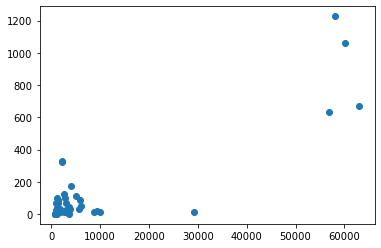

In [10]:
plt.scatter(X, y)
plt.show()

In [11]:
# Create our training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52)

In [12]:
# Create and train regression model
econ_model = LinearRegression()

econ_model.fit(X_train, y_train)

LinearRegression()

In [13]:
# Create some predictions based on our X-test set
econ_predictions = econ_model.predict(X_test)
econ_predictions

array([ 99.58535954,  76.27184099,  40.42248728, 176.27102974,
        41.88124592, 911.11051624, 479.33487029,  39.89071996,
        32.64706572,  32.75323128,  40.10242474, 167.23771853])

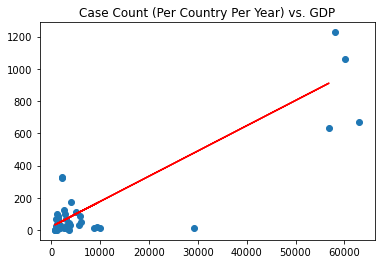

In [14]:
# Chart our data and prediction
plt.scatter(X, y)
plt.title("Case Count (Per Country Per Year) vs. GDP")
plt.plot(X_test, econ_predictions, color='red')
plt.savefig("fig_xx_cases_v_gdp", transparent=True)
plt.show()